**Add your LiU-ID here:**
* <liuid 1>
* <liuid 2>

### **Quick introduction to jupyter notebooks**
* Each cell in this notebook contains either code or text.
* You can run a cell by pressing Ctrl-Enter, or run and advance to the next cell with Shift-Enter.
* Code cells will print their output, including images, below the cell. Running it again deletes the previous output, so be careful if you want to save some results.
* You don't have to rerun all cells to test changes, just rerun the cell you have made changes to. Some exceptions might apply, for example if you overwrite variables from previous cells, but in general this will work.
* If all else fails, use the "Kernel" menu and select "Restart Kernel and Clear All Output". You can also use this menu to run all cells.
* A useful debug tool is the console. You can right-click anywhere in the notebook and select "New console for notebook". This opens a python console which shares the environment with the notebook, which let's you easily print variables or test commands.

### **Setup**

In [4]:
import os
import tensorflow as tf

# If there are multiple GPUs and we only want to use one/some, set the number in the visible device list.
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# This sets the GPU to allocate memory only as needed
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) != 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True) 

### **1. Loading the dataset**
This assignment will focus on the CIFAR10 dataset. This is a collection of small images in 10 classes such as cars, cats, birds, etc. You can find more information here: https://www.cs.toronto.edu/~kriz/cifar.html. We start by loading and examining the data.

In [5]:
import numpy as np
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print("Shape of traini   ng data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


#### **<span style="color:red">Question 1:</span>**
The shape of X_train and X_test has 4 values. What do each of these represent?

#### **<span style="color:green">Answer:</span>**
First value is the number of pictures, second and third represent pixel coordinate and fourth array represent a color in rgb.

##### **Plotting some images**
This plots a random selection of images from each class. Rerun the cell to see a different selection.

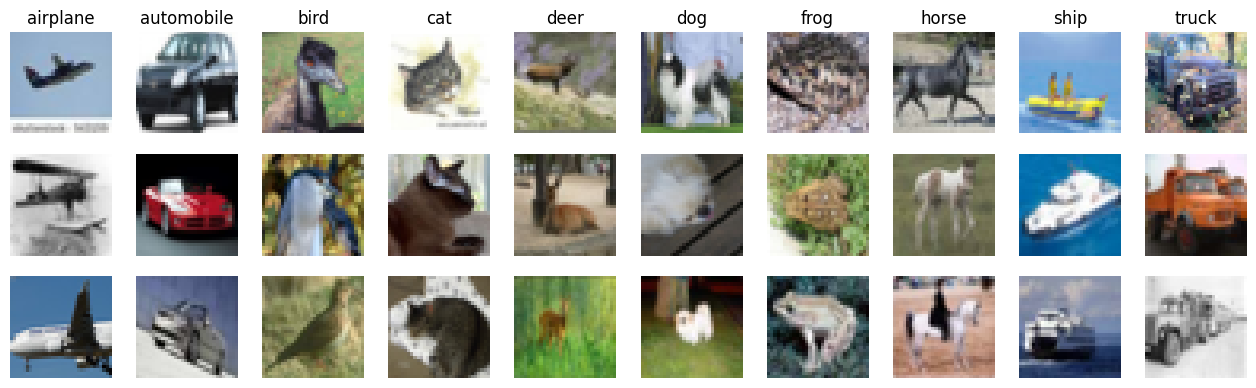

In [6]:
from Custom import PlotRandomFromEachClass

cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
PlotRandomFromEachClass(X_train, y_train, 3, labels=cifar_labels)

##### **Preparing the dataset**
Just like the MNIST dataset we normalize the images to [0,1] and transform the class indices to one-hot encoded vectors.

In [7]:
from tensorflow.keras.utils import to_categorical

# Transform label indices to one-hot encoded vectors
y_train_c = to_categorical(y_train, num_classes=10)
y_test_c  = to_categorical(y_test , num_classes=10)

# Normalization of pixel values (to [0-1] range)
X_train = X_train.astype('float32') / 255
X_test  = X_test.astype('float32')  / 255

##### **Training and evaluating the model**
Below, we define a function that performs model training and evaluation. The first input parameter is another function that you will write, that creates and returns the model object in each task.

In order to show the differences between models in the first parts of the assignment, we will restrict the training to the following command using 15 epochs, batch size 32, and 20% validation data. From section 5 and forward you can change this as you please to increase the accuracy, but for now stick with this command.

We use ```model.evaluate``` to get the loss and metric scores on the test data. To plot the results we give you a custom function that does the work for you.

In [8]:
from Custom import PlotModelEval

def TrainModelAndPlotResults(get_model_func, epochs=15, batch_size=32):
    # Get model using function handle parameter
    model = get_model_func()

    # Build the model using Stochastic Gradient Descent with Nesterov momentum. We use accuracy as the metric.
    sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary(100)

    # Train the model and store the training history
    history = model.fit(X_train,y_train_c, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2)

    # Evaluate on the test set and store the score
    score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

    # Print the result metrics
    print("")
    print('_' * 100)
    for i in range(len(score)):
        print("Test " + model.metrics_names[i] + " = %.3f" % score[i])
    print("")

    # Plot the training history and results
    PlotModelEval(model, history, X_test, y_test, cifar_labels)

### **2. Fully connected classifier**
We will start by creating a fully connected classifier using the ```Dense``` layer. We give you the first layer that flattens the image features to a single vector. Add the remaining layers to the network.

Consider what the size of the output must be and what activation function you should use in the output layer.

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)                 │ (None, 32, 32, 3)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ flatten_1 (Flatten)                        │ (None, 3072)                    │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_4 (Dense)                            │ (None, 512)                     │         1,573,376 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_5 (Dense)                            │ (None, 256)                     │           131,328 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_6 (Dense)                            │ (None, 128)                     │            32,896 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_7 (Dense)                            │ (None, 10)                      │             1,290 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 1,738,890 (6.63 MB)

 Trainable params: 1,738,890 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2910 - loss: 1.9459 - val_accuracy: 0.3545 - val_loss: 1.7685
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3927 - loss: 1.6896 - val_accuracy: 0.4140 - val_loss: 1.6317
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4277 - loss: 1.5992 - val_accuracy: 0.4298 - val_loss: 1.6153
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4446 - loss: 1.5383 - val_accuracy: 0.4221 - val_loss: 1.6146
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4647 - loss: 1.4867 - val_accuracy: 0.4668 - val_loss: 1.5220
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4814 - loss: 1.4490 - val_accuracy: 0.4669 - val_loss: 1.4957
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4851 - loss: 1.4310 - val_accuracy: 0.4587 - val_loss: 1.5209
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4946 - loss: 1.3939 - 

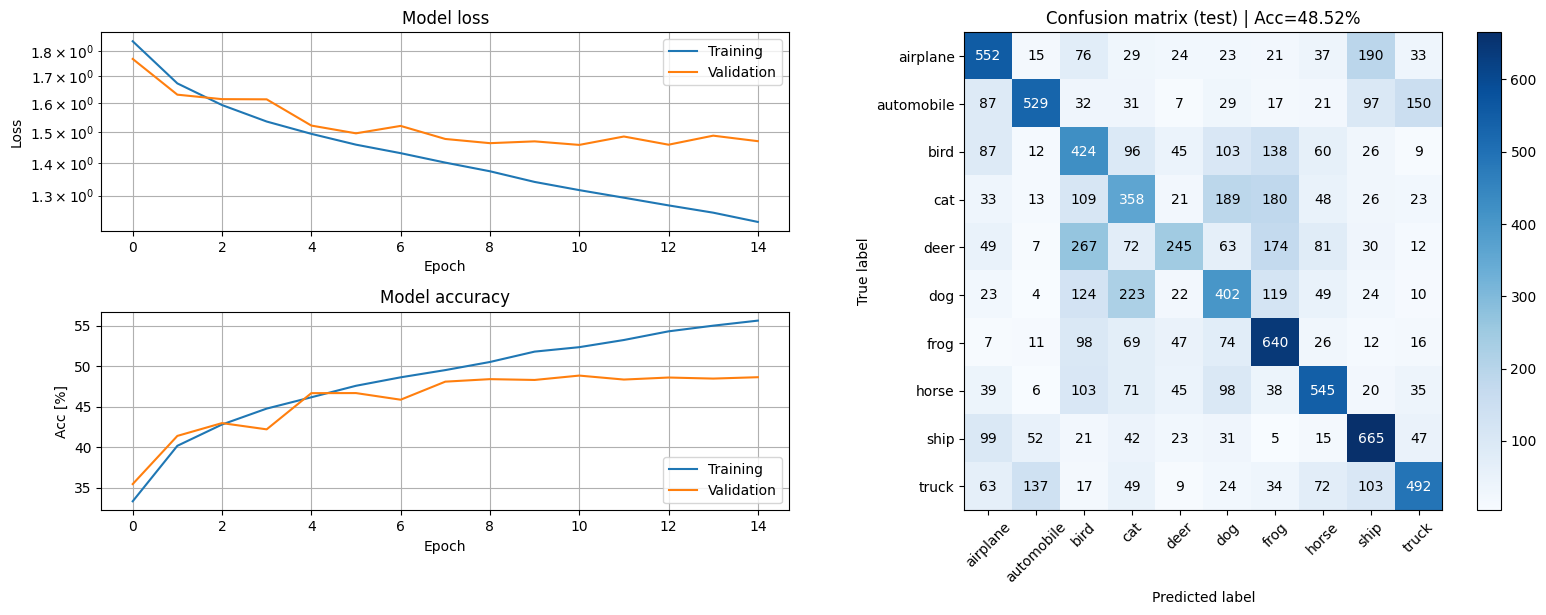

In [10]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense

def CreateFullyConnectedModel(): 

    x_in = Input(shape=X_train.shape[1:])
    input = Flatten()(x_in)
    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------
    x = Dense(512, activation="relu")(input)
    x2 = Dense(256, activation="relu")(x)
    x3 = Dense(128, activation="relu")(x2)
    output = Dense(10, activation="softmax")(x3)
    
    # ============================================
    
    model = Model(inputs=x_in, outputs=output)
    return model

# Run training on the fully connected model
TrainModelAndPlotResults(CreateFullyConnectedModel)

#### **<span style="color:red">Question 2:</span>**
Train a model that achieves above 45% accuracy on the test data. Provide a (short) motivation of your model architecture and briefly discuss the results.

#### **<span style="color:green">Answer:</span>**
We got an accuracy of 49.49%. We choose an architechture of a flatten layer and 3 fully connected hidden layers in the middle followed by output layer with 10 neurons since we have 10 different classes. The number of neutrons is reduced beetween every layer to create a pyramid form and then gradualy reduces the number to refine them.

#### **<span style="color:red">Question 3:</span>**
Compare this model to the one you used for the MNIST dataset in the first assignment, in terms of size and test accuracy. Why do you think this dataset is much harder to classify than the MNIST handwritten digits?

#### **<span style="color:green">Answer:</span>**
The clusters arent as separated in the -minst dataset. We had an test accuracy of 96,9%. The pictures are way bigger 32x32 compared to 8x8. We also have rgb colors instead of just black and white.

### **3. CNN classifier**
We will now move on to a network architecture that is more suited for this problem, the convolutional neural network. The new layers you will use are ```Conv2D``` and ```MaxPooling2D```, which you can find the documentation of here https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D and here https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D.

##### **Creating the CNN model**

A common way to build convolutional neural networks is to create blocks of layers of the form **[convolution - activation - pooling]**, and then stack several of these block to create the full convolution stack. This is often followed by a fully connected network to create the output classes. Use this recipe to build a CNN that acheives at least 62% accuracy on the test data.

*Side note. Although this is a common way to build CNNs, it is be no means the only or even best way. It is a good starting point, but later in part 5 you might want to explore other architectures to acheive even better performance.*

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)                 │ (None, 32, 32, 3)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_3 (Conv2D)                          │ (None, 30, 30, 32)              │               896 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_3 (MaxPooling2D)             │ (None, 15, 15, 32)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_4 (Conv2D)                          │ (None, 13, 13, 64)              │            18,496 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_4 (MaxPooling2D)             │ (None, 6, 6, 64)                │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_5 (Conv2D)                          │ (None, 4, 4, 128)               │            73,856 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_5 (MaxPooling2D)             │ (None, 2, 2, 128)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ flatten_3 (Flatten)                        │ (None, 512)                     │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_12 (Dense)                           │ (None, 512)                     │           262,656 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_13 (Dense)                           │ (None, 256)                     │           131,328 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_14 (Dense)                           │ (None, 128)                     │            32,896 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_15 (Dense)                           │ (None, 10)                      │             1,290 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 521,418 (1.99 MB)

 Trainable params: 521,418 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2666 - loss: 1.9581 - val_accuracy: 0.5045 - val_loss: 1.3789
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5291 - loss: 1.3030 - val_accuracy: 0.6005 - val_loss: 1.1339
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6162 - loss: 1.0785 - val_accuracy: 0.6446 - val_loss: 1.0147
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6778 - loss: 0.9160 - val_accuracy: 0.6599 - val_loss: 0.9712
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7214 - loss: 0.7934 - val_accuracy: 0.6821 - val_loss: 0.9285
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7577 - loss: 0.6936 - val_accuracy: 0.6779 - val_loss: 0.9589
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7851 - loss: 0.6116 - val_accuracy: 0.6969 - val_loss: 0.9101
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8131 - loss: 0.5285 - 

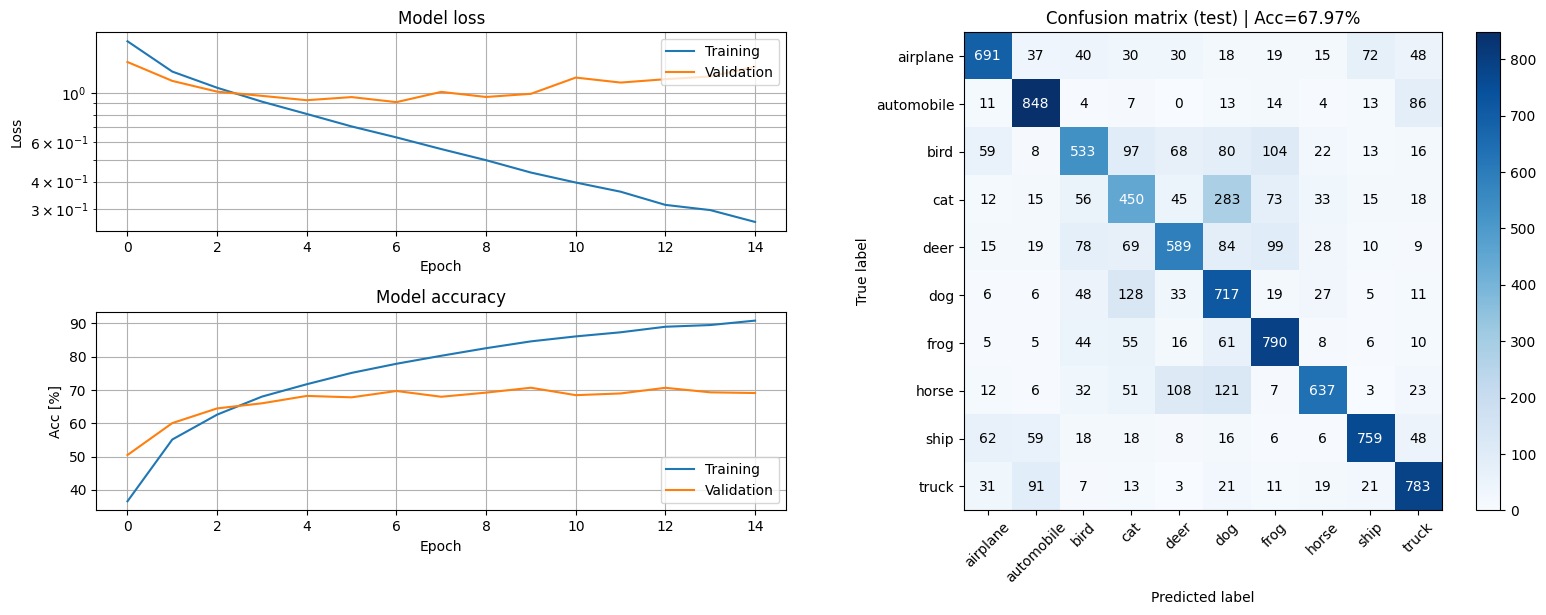

In [12]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

def CreateCNNModel():

    x_in = Input(shape=X_train.shape[1:])
    
    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------
    # Block 1
    x = Conv2D(32, (3,3), activation="relu")(x_in)
    x = MaxPooling2D(pool_size=(2,2))(x)
    # Block 2
    x = Conv2D(64, (3,3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    # Block 3
    x = Conv2D(128, (3,3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Flatten()(x)
    x = Dense(512, activation="relu")(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(10, activation="softmax")(x)
    
    # ============================================
    
    model = Model(inputs=x_in, outputs=x)
    return model

# Run training on the CNN model
TrainModelAndPlotResults(CreateCNNModel)

#### **<span style="color:red">Question 4:</span>**
Train a model that achieves at least 62% test accuracy. Provide a (short) motivation of your model architecture and briefly discuss the results.

#### **<span style="color:green">Answer:</span>**
We got an accuracy of 68.47%. We choose an architechture of 3 blocks where features are extracted using convlution and then the size is reduced by pooling. This is done to capture more complex features. The architechture also includes a flatten layer and then 3 fully connected hidden layers in the middle followed by an output layer with 10 neurons since we have 10 different classes. The number of neutrons is reduced beetween every layer to create a pyramid form and then gradualy reduces the number to refine them.

#### **<span style="color:red">Question 5:</span>**
Compare this model with the previous fully connected model. You should find that this one is much more efficient, i.e. achieves higher accuracy with fewer parameters. Explain in your own words how this is possible.

#### **<span style="color:green">Answer:</span>**
Since we capture more complex features we also gets higher accuracy however since the model is more comlex we gets a higher execution time. 

### **4. Regularization**

#### **4.1 Dropout**
You have probably seen that your CNN model overfits the training data. One way to prevent this is to add ```Dropout``` layers to the model, that randomly "drops" hidden nodes each training-iteration by setting their output to zero. Thus the model cannot rely on a small set of very good hidden features, but must instead learns to use different sets of hidden features each time. Dropout layers are usually added after the pooling layers in the convolution part of the model, or after activations in the fully connected part of the model.

*Side note. In the next assignment you will work with Ensemble models, a way to use the output from several individual models to achieve higher performance than each model can achieve on its own. One way to interpret Dropout is that each random selection of nodes is a separate model that is trained only on the current iteration. The final output is then the average of outputs from all the individual models. In other words, Dropout can be seen as a way to build ensembling directly into the network, without having to train several models explicitly.*

Extend your previous model with the Dropout layer and test the new performance.

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)                 │ (None, 32, 32, 3)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_6 (Conv2D)                          │ (None, 30, 30, 32)              │               896 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_6 (MaxPooling2D)             │ (None, 15, 15, 32)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout (Dropout)                          │ (None, 15, 15, 32)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_7 (Conv2D)                          │ (None, 13, 13, 64)              │            18,496 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_7 (MaxPooling2D)             │ (None, 6, 6, 64)                │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout_1 (Dropout)                        │ (None, 6, 6, 64)                │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_8 (Conv2D)                          │ (None, 4, 4, 128)               │            73,856 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_8 (MaxPooling2D)             │ (None, 2, 2, 128)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout_2 (Dropout)                        │ (None, 2, 2, 128)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ flatten_4 (Flatten)                        │ (None, 512)                     │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_16 (Dense)                           │ (None, 512)                     │           262,656 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout_3 (Dropout)                        │ (None, 512)                     │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_17 (Dense)                           │ (None, 256)                     │           131,328 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout_4 (Dropout)                        │ (None, 256)                     │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_18 (Dense)                           │ (None, 128)                     │            32,896 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_19 (Dense)                           │ (None, 10)                      │             1,290 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 521,418 (1.99 MB)

 Trainable params: 521,418 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.1585 - loss: 2.1719 - val_accuracy: 0.3221 - val_loss: 1.8103
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3330 - loss: 1.7604 - val_accuracy: 0.4513 - val_loss: 1.5149
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4222 - loss: 1.5640 - val_accuracy: 0.4988 - val_loss: 1.3909
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4722 - loss: 1.4544 - val_accuracy: 0.5359 - val_loss: 1.2866
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5064 - loss: 1.3790 - val_accuracy: 0.5710 - val_loss: 1.2348
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5226 - loss: 1.3286 - val_accuracy: 0.5671 - val_loss: 1.2042
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5467 - loss: 1.2708 - val_accuracy: 0.5882 - val_loss: 1.1597
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5642 - loss: 1.2329 - 

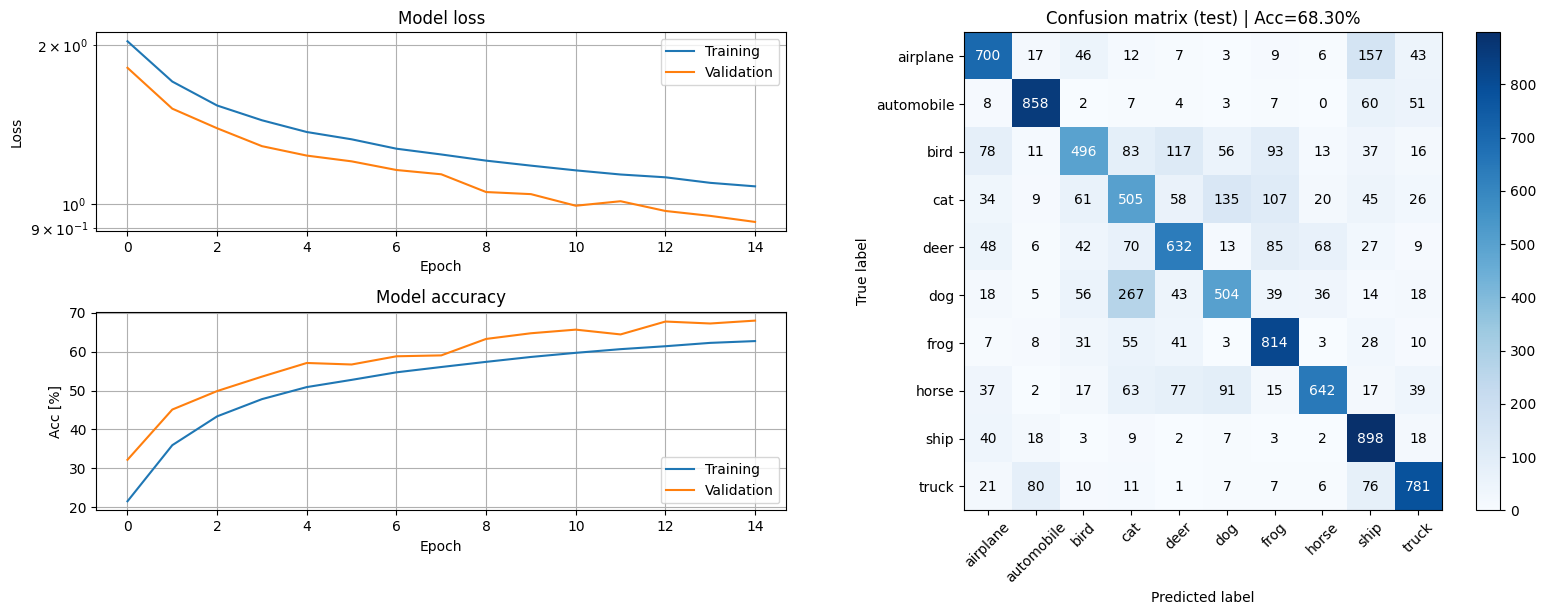

In [13]:
from tensorflow.keras.layers import Dropout

def CreateDropoutModel():

    x_in = Input(shape=X_train.shape[1:])
    
    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------

    # Block 1
    x = Conv2D(32, (3,3), activation="relu")(x_in)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    # Block 2
    x = Conv2D(64, (3,3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    # Block 3
    x = Conv2D(128, (3,3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(10, activation="softmax")(x)
    
    # ============================================
    
    model = Model(inputs=x_in, outputs=x)
    return model

# Run training on the Dropout model
TrainModelAndPlotResults(CreateDropoutModel)

#### **<span style="color:red">Question 6:</span>**
Compare this model and the previous in terms of the training accuracy, validation accuracy, and test accuracy. Explain the similarities and differences (remember that the only difference between the models should be the addition of Dropout layers).

Hint: what does the dropout layer do at test time?

#### **<span style="color:green">Answer:</span>**
Without dropput:
Training accuracy: 91.60%
Validation accuracy: 69.45%
Testing accuracy:68.47%

With dropput:
Training accuracy: 60.94%
Validation accuracy: 64.93%
Testing accuracy:64.61%

As we can see the training accuracy is decreased with dropout making it closer to the validation and testing accuracy preventing overfitting of the training data.

#### **4.2 Batch normalization**
The final layer we will explore is ```BatchNormalization```. As the name suggests, this layer normalizes the data in each batch to have a specific mean and standard deviation, which is learned during training. The reason for this is quite complicated (and still debated among the experts), but suffice to say that it helps the optimization converge faster which means we get higher performance in fewer epochs. The normalization is done separatly for each feature, i.e. the statistics are calculated accross the batch dimension of the input data. The equations for batch-normalizing one feature are the following, where $N$ is the batch size, $x$ the input features, and $y$ the normalized output features:

$$ \mu = \frac{1}{N} \sum_{i=0}^{N}x_i,\;\;\;\; \sigma^2 = \frac{1}{N} \sum_{i=0}^{N}(x_i - \mu)^2 $$

$$ \hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} $$

$$ y_i = \gamma \hat{x}_i + \beta $$

At first glance this might look intimidating, but all it means is that we begin by scaling and shifting the data to have mean $\mu=0$ and standard deviation $\sigma=1$. After this we use the learnable parameters $\gamma$ and $\beta$ to decide the width and center of the final distribution. $\epsilon$ is a small constant value that prevents the denominator from being zero.

In addition to learning the parameters $\gamma$ and $\beta$ by gradient decent just like the weights, Batch Normalization also keeps track of the running average of minibatch statistics $\mu$ and $\sigma$. These averages are used to normalize the test data. We can tune the rate at which the running averages are updated with the *momentum* parameter of the BatchNormalization layer. A large momentum means that the statistics converge more slowly and therefore requires more updates before it represents the data. A low momentum, on the other hand, adapts to the data more quickly but might lead to unstable behaviour if the latest minibatches are not representative of the whole dataset. For this test we recommend a momentum of 0.75, but you probably want to change this when you design a larger network in Section 5.

The batch normalization layer should be added after the hidden layer linear transformation, but before the nonlinear activation. This means that we cannot specify the activation funciton in the ```Conv2D``` or ```Dense``` if we want to batch-normalize the output. We therefore need to use the ```Activation``` layer to add a separate activation to the network stack after batch normalization. For example, the convolution block will now look like **[conv - batchnorm - activation - pooling]**.

Extend your previous model with batch normalization, both in the convolution and fully connected part of the model.

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)                 │ (None, 32, 32, 3)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_12 (Conv2D)                         │ (None, 30, 30, 32)              │               896 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_6 (BatchNormalization) │ (None, 30, 30, 32)              │               128 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ activation_6 (Activation)                  │ (None, 30, 30, 32)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_12 (MaxPooling2D)            │ (None, 15, 15, 32)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout_10 (Dropout)                       │ (None, 15, 15, 32)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_13 (Conv2D)                         │ (None, 13, 13, 64)              │            18,496 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_7 (BatchNormalization) │ (None, 13, 13, 64)              │               256 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ activation_7 (Activation)                  │ (None, 13, 13, 64)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_13 (MaxPooling2D)            │ (None, 6, 6, 64)                │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout_11 (Dropout)                       │ (None, 6, 6, 64)                │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_14 (Conv2D)                         │ (None, 4, 4, 128)               │            73,856 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_8 (BatchNormalization) │ (None, 4, 4, 128)               │               512 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ activation_8 (Activation)                  │ (None, 4, 4, 128)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_14 (MaxPooling2D)            │ (None, 2, 2, 128)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout_12 (Dropout)                       │ (None, 2, 2, 128)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ flatten_6 (Flatten)                        │ (None, 512)                     │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_24 (Dense)                           │ (None, 512)                     │           262,656 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_9 (BatchNormalization) │ (None, 512)   

 Total params: 525,898 (2.01 MB)

 Trainable params: 523,658 (2.00 MB)

 Non-trainable params: 2,240 (8.75 KB)

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.2698 - loss: 1.9760 - val_accuracy: 0.4076 - val_loss: 1.5820
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4401 - loss: 1.5234 - val_accuracy: 0.5191 - val_loss: 1.3358
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5035 - loss: 1.3701 - val_accuracy: 0.4911 - val_loss: 1.4875
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5408 - loss: 1.2796 - val_accuracy: 0.5558 - val_loss: 1.2718
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5663 - loss: 1.2161 - val_accuracy: 0.5450 - val_loss: 1.2857
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5916 - loss: 1.1590 - val_accuracy: 0.6640 - val_loss: 0.9389
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6058 - loss: 1.1174 - val_accuracy: 0.6151 - val_loss: 1.0914
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6252 - loss: 1.0726 - 

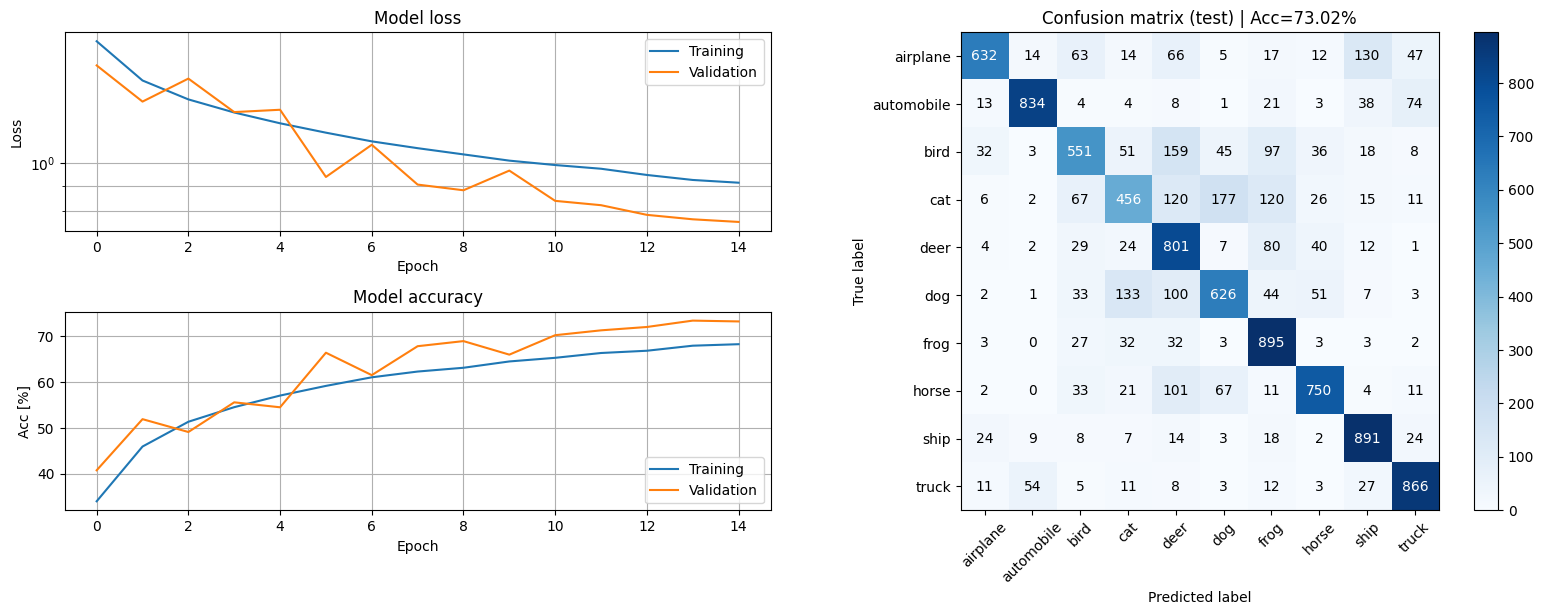

In [15]:
from tensorflow.keras.layers import BatchNormalization, Activation

def CreateBatchNormModel():
    
    x_in = Input(shape=X_train.shape[1:])
    
    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------

        # Block 1
    x = Conv2D(32, (3,3))(x_in)
    x = BatchNormalization(momentum=0.75)(x)
    x = Activation(activation="relu")(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    # Block 2
    x = Conv2D(64, (3,3))(x)
    x = BatchNormalization(momentum=0.75)(x)
    x = Activation(activation="relu")(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    # Block 3
    x = Conv2D(128, (3,3))(x)
    x = BatchNormalization(momentum=0.75)(x)
    x = Activation(activation="relu")(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(512)(x)
    x = BatchNormalization(momentum=0.75)(x)
    x = Activation(activation="relu")(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256)(x)
    x = BatchNormalization(momentum=0.75)(x)
    x = Activation(activation="relu")(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128)(x)
    x = BatchNormalization(momentum=0.75)(x)
    x = Activation(activation="relu")(x)
    x = Dense(10, activation="softmax")(x)
    
    # ============================================
    
    model = Model(inputs=x_in, outputs=x)
    return model

# Run training on the BatchNorm model
TrainModelAndPlotResults(CreateBatchNormModel)

#### **<span style="color:red">Question 7:</span>**
When using BatchNorm one must take care to select a good minibatch size. Describe what problems might arise if:

1. The minibatch size is too small.

3. The minibatch size is too large.


You can reason about this given the description of BatchNorm above, or you can search for the information in other sources. Do not forget to provide links to the sources if you do!

#### **<span style="color:green">Answer:</span>**
1. 
The result may not be accurate on all parts of the dataset.https://www.pingcap.com/article/understanding-the-impact-of-batch-normalization-on-cnns/

2
A larger batch size require more memory and larger computational power, could potentially be limited by the computer.

### **5. Putting it all together**
We now want you to create your own model based on what you have learned. We want you to experiment and see what works and what doesn't, so don't go crazy with the number of epochs until you think you have something that works.

To pass this assignment, we want you to acheive **75%** accuracy on the test data in no more than **25 epochs**. This is possible using the layers and techniques we have explored in this notebook, but you are free to use any other methods that we didn't cover. (You are obviously not allowed to cheat, for example by training on the test data.)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)                 │ (None, 32, 32, 3)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_21 (Conv2D)                         │ (None, 30, 30, 64)              │             1,792 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_24                     │ (None, 30, 30, 64)              │               256 │
│ (BatchNormalization)                       │                                 │                   │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ activation_24 (Activation)                 │ (None, 30, 30, 64)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_21 (MaxPooling2D)            │ (None, 15, 15, 64)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout_25 (Dropout)                       │ (None, 15, 15, 64)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_22 (Conv2D)                         │ (None, 13, 13, 128)             │            73,856 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_25                     │ (None, 13, 13, 128)             │               512 │
│ (BatchNormalization)                       │                                 │                   │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ activation_25 (Activation)                 │ (None, 13, 13, 128)             │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_22 (MaxPooling2D)            │ (None, 6, 6, 128)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout_26 (Dropout)                       │ (None, 6, 6, 128)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_23 (Conv2D)                         │ (None, 4, 4, 256)               │           295,168 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_26                     │ (None, 4, 4, 256)               │             1,024 │
│ (BatchNormalization)                       │                                 │                   │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ activation_26 (Activation)                 │ (None, 4, 4, 256)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_23 (MaxPooling2D)            │ (None, 2, 2, 256)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout_27 (Dropout)                       │ (None, 2, 2, 256)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ flatten_9 (Flatten)                        │ (None, 1024)                    │                 0 │
├────────────────────────────────────────────┼───────────────

 Total params: 1,066,506 (4.07 MB)

 Trainable params: 1,063,818 (4.06 MB)

 Non-trainable params: 2,688 (10.50 KB)

Epoch 1/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.2922 - loss: 1.9180 - val_accuracy: 0.4835 - val_loss: 1.4073
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4720 - loss: 1.4420 - val_accuracy: 0.5020 - val_loss: 1.3314
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5312 - loss: 1.2980 - val_accuracy: 0.6211 - val_loss: 1.0474
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5803 - loss: 1.1823 - val_accuracy: 0.6126 - val_loss: 1.0586
Epoch 5/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6100 - loss: 1.1027 - val_accuracy: 0.6529 - val_loss: 0.9706
Epoch 6/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6228 - loss: 1.0539 - val_accuracy: 0.6661 - val_loss: 0.9258
Epoch 7/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6463 - loss: 1.0064 - val_accuracy: 0.7152 - val_loss: 0.8181
Epoch 8/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6663 - loss: 0.9536 - 

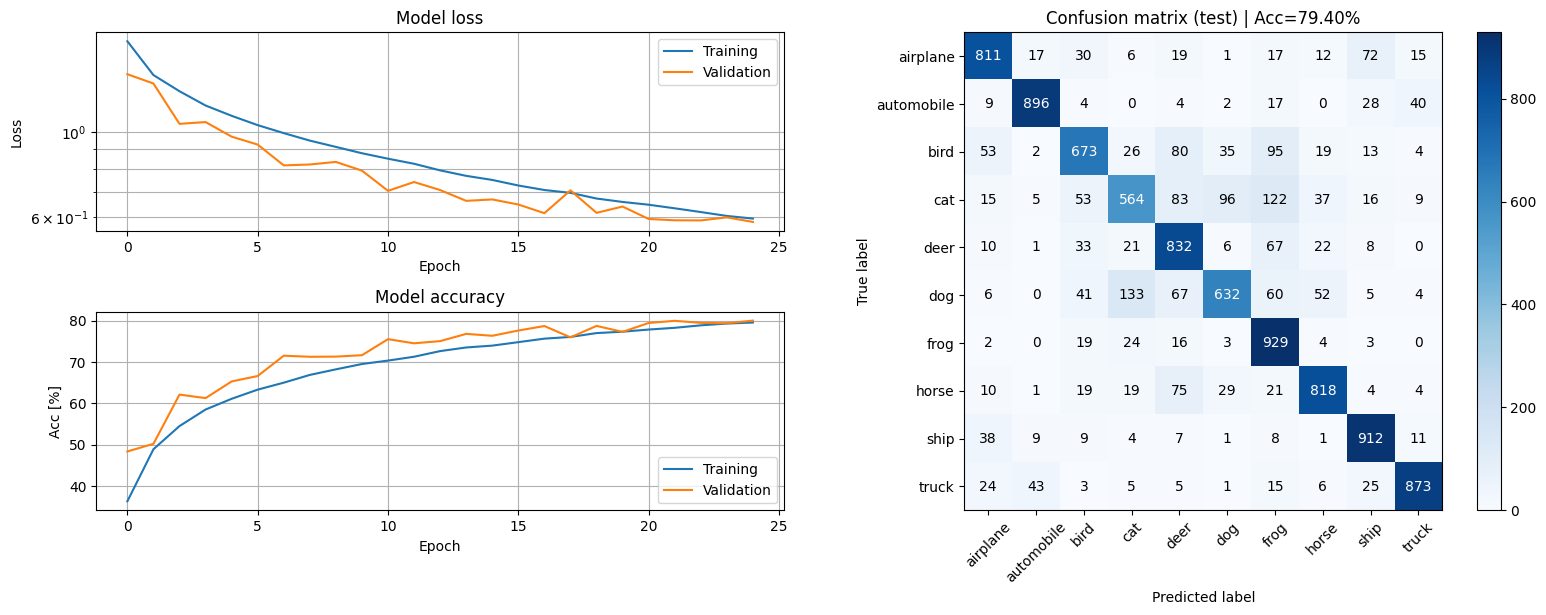

In [18]:
def CreateFinalModel():

    x_in = Input(shape=X_train.shape[1:])
    
    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------

        # Block 1
    x = Conv2D(64, (3,3))(x_in)
    x = BatchNormalization(momentum=0.75)(x)
    x = Activation(activation="relu")(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    # Block 2
    x = Conv2D(128, (3,3))(x)
    x = BatchNormalization(momentum=0.75)(x)
    x = Activation(activation="relu")(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    # Block 3
    x = Conv2D(256, (3,3))(x)
    x = BatchNormalization(momentum=0.75)(x)
    x = Activation(activation="relu")(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(512)(x)
    x = BatchNormalization(momentum=0.75)(x)
    x = Activation(activation="relu")(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256)(x)
    x = BatchNormalization(momentum=0.75)(x)
    x = Activation(activation="relu")(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128)(x)
    x = BatchNormalization(momentum=0.75)(x)
    x = Activation(activation="relu")(x)
    x = Dense(10, activation="softmax")(x)
    
    
    # ============================================
    
    model = Model(inputs=x_in, outputs=x)
    return model

# Run training on the final model
TrainModelAndPlotResults(CreateFinalModel, epochs=25)

#### **<span style="color:red">Question 8:</span>**
Design and train a model that achieves at least 75% test accuracy in at most 25 epochs. Explain your model architecture and motivate the design choices you have made.

#### **<span style="color:green">Answer:</span>**
79,4 %. We used 3 blocks including  **[conv - batchnorm - activation - pooling-dropout]** and then 1 flatten layer followed by 3 hidden layers with dropout and an exiting layer with 10 neurons since there are 10 classes. We choose to increase the number of filters in the blocks to extract more features and thereby increase the test accuracy to above 75%.

---

### **Want some extra challenge?**
For those of you that want to get creative, here are some things to look into. But note that we don't have the answers here. Any of these might improve the performance, or might not, or it might only work in combination with each other. This is up to you to figure out. This is how deep learning research often happens, trying things in a smart way to see what works best.
* Tweak or change the optimizer or training parameters.
* Tweak the filter parameters, such as numbers and sizes of filters.
* Use other activation functions.
* Add L1/L2 regularization (see https://www.tensorflow.org/api_docs/python/tf/keras/regularizers)
* Include layers that we did not cover here (see https://www.tensorflow.org/api_docs/python/tf/keras/layers). For example, our best model uses the global pooling layers.
* Take inspiration from some well-known architectures, such as ResNet or VGG16. (But don't just copy-paste those architectures. For one, what's the fun in that? Also, they take a long time to train, you will not have time.)
* Use explicit model ensembing (training multiple models that vote on or average the outputs - this will also take a lot of time.)
* Use data augmentation to create a larger training set (see https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).